In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sep = os.sep

In [3]:
m1_usa = pd.read_parquet('..' + sep + 'data' + sep + "M1NS" + sep +"M1NS.parquet")
m2_usa = pd.read_parquet('..' + sep + 'data' + sep + "M2NS" + sep +"M2NS.parquet")
cpi_usa = pd.read_parquet('..' + sep + 'data' + sep + 'CPIAUCNS' + sep +"CPIAUCNS.parquet")
pce_usa = pd.read_parquet('..' + sep + 'data' + sep + 'PCEPI' + sep +"PCEPI.parquet")

In [4]:
m2_usa = m2_usa.pct_change(12).shift(34).dropna()
m2_usa.rename(columns={'Value': 'M2'}, inplace=True)

In [5]:
cpi_usa = cpi_usa.pct_change(12).dropna()
cpi_usa.rename(columns={'Value': 'CPI'}, inplace=True)

In [6]:
ready_dataframe = pd.concat([m2_usa, cpi_usa], axis=1)

In [7]:
ready_dataframe.dropna(inplace=True)

In [8]:
ready_dataframe

,M2,CPI
1962-11-01,0.040373,0.013333
1962-12-01,0.037539,0.013333
1963-01-01,0.035776,0.013333
1963-02-01,0.034804,0.009967
1963-03-01,0.029979,0.013289
...,...,...
2021-02-01,0.037421,0.016762
2021-03-01,0.038564,0.026198
2021-04-01,0.041858,0.041597
2021-05-01,0.039643,0.049927


In [9]:
X = ready_dataframe[['M2']]
y = ready_dataframe['CPI']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle      = True
                                    )

In [10]:
lm = LinearRegression()

In [11]:
lm.fit(X_train, y_train)

LinearRegression()

In [12]:
print("Intercept:", lm.intercept_)
print("Coeficiente:", list(zip(X.columns, lm.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", lm.score(X, y))

Intercept: [0.00161471]
Coeficiente: [('M2', 0.5103285623727901)]
Coeficiente de determinación R^2: 0.2691392571156376


In [13]:
predicciones = lm.predict(X = X_test)
print(predicciones[0:3,])

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

[[0.04126688]
 [0.02782868]
 [0.03793372]]

El error (rmse) de test es: 0.025872563978047457


In [14]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     200.6
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           3.81e-39
Time:                        20:14:36   Log-Likelihood:                 1305.5
No. Observations:                 563   AIC:                            -2607.
Df Residuals:                     561   BIC:                            -2598.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.607      0.5

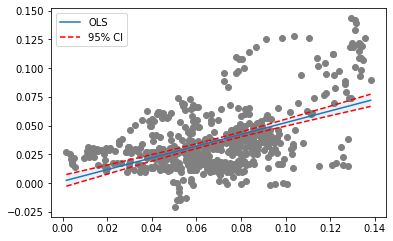

In [15]:
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones['x'] = X_train[:, 1]
predicciones['y'] = y_train
predicciones = predicciones.sort_values('x')

# Gráfico del modelo
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))

ax.scatter(predicciones['x'], predicciones['y'], marker='o', color = "gray")
ax.plot(predicciones['x'], predicciones["mean"], linestyle='-', label="OLS")
ax.plot(predicciones['x'], predicciones["mean_ci_lower"], linestyle='--', color='red', label="95% CI")
ax.plot(predicciones['x'], predicciones["mean_ci_upper"], linestyle='--', color='red')
ax.fill_between(predicciones['x'], predicciones["mean_ci_lower"], predicciones["mean_ci_upper"], alpha=0.1)
ax.legend();

In [16]:
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")


El error (rmse) de test es: 0.02587256397804745
